In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask.distributed import Client
from scipy.stats import norm

from uncle_val.datasets.dp1 import dp1_catalog_multi_band
from uncle_val.whitening import whiten_data

In [2]:
dp1_root = Path("../../data/dp1")
BANDS = "ugrizy"
MIN_N_SRC = 10

In [3]:
catalog = dp1_catalog_multi_band(
    dp1_root,
    bands=BANDS,
    obj="science",
    img="diff",
    phot="PSF",
    mode="forced",
)
catalog

,id,coord_ra,coord_dec,lc,band,object_mag,extendedness,is_u_band,is_g_band,is_r_band,is_i_band,is_z_band,is_y_band
npartitions=389,,,,,,,,,,,,,
"Order: 6, Pixel: 130",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<x: [float], err: [float]>",object,float[pyarrow],float[pyarrow],bool,bool,bool,bool,bool,bool
"Order: 8, Pixel: 2176",...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
def extract_hists(df, *, z_bins, mag_bins, bands, min_n_src, non_extended):
    df = df[df["lc"].nest.list_lengths >= min_n_src]

    if non_extended:
        df = df.query("extendedness == 0.0")

    if len(df) == 0:
        return pd.DataFrame(
            {
                "band": np.array([], dtype=str),
                "mag_bin_idx": np.array([], dtype=int),
                "z_bin_idx": np.array([], dtype=int),
                "count": np.array([], dtype=int),
            }
        )

    whiten = (
        df.reduce(
            lambda x, err: {"whiten.z": whiten_data(x, err**2)},
            "lc.x",
            "lc.err",
            append_columns=True,
        )
        .drop(
            columns=["lc"],
        )
        .reset_index(
            drop=True,
        )
    )

    mag_idx_grid, z_idx_grid = np.indices((len(mag_bins) - 1, len(z_bins) - 1))

    result_dfs = []
    for band in bands:
        monochrome = whiten.query(f"band=='{band}'")
        z_mag = monochrome[["object_mag"]].join(monochrome["whiten"].nest.to_flat())
        hist, _mag_bins, _z_bins = np.histogram2d(z_mag["object_mag"], z_mag["z"], bins=[mag_bins, z_bins])
        result_dfs.append(
            pd.DataFrame(
                {
                    "band": band,
                    "mag_bin_idx": mag_idx_grid.flatten(),
                    "z_bin_idx": z_idx_grid.flatten(),
                    "count": hist.flatten(),
                }
            )
        )
    return pd.concat(result_dfs)

In [5]:
z_bins = np.r_[-10:10:1001j]
z_width = z_bins[1] - z_bins[0]
z_centers = 0.5 * (z_bins[1:] + z_bins[:-1])

mag_bins = np.arange(13, 27, 0.5)
mag_width = mag_bins[1] - mag_bins[0]
mag_centers = 0.5 * (mag_bins[1:] + mag_bins[:-1])

hists = catalog.map_partitions(
    extract_hists,
    z_bins=z_bins,
    mag_bins=mag_bins,
    bands=BANDS,
    min_n_src=MIN_N_SRC,
    non_extended=True,
)

In [6]:
with Client(n_workers=8, threads_per_worker=1, memory_limit="8GB") as client:
    display(client)
    hists_df = hists.compute()
hists_df.head(5)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58118,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:58138,Total threads: 1
Dashboard: http://127.0.0.1:58141/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:58121,


2025-09-30 17:00:52,520 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:58158 (pid=10967) exceeded 95% memory budget. Restarting...
2025-09-30 17:00:52,786 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-8b4ce66c30253699e479232ed6f2c7f6', 0): 'memory'}
2025-09-30 17:00:52,787 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:58158' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('repartitiontofewer-8b4ce66c30253699e479232ed6f2c7f6', 0)} (stimulus_id='handle-worker-cleanup-1759266052.786837')
2025-09-30 17:00:52,839 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-8b4ce66c30253699e479232ed6f2c7f6', 0),)
2025-09-30 17:00:52,841 - distributed.nanny - WARNING - Restarting worker
2025-09-30 17:02:07,352 - distributed.worker.memory - WARNING - Worker is at 92% memory usage. Pausing worker.  Process memory: 6.92 GiB -- Worker memory limit: 7.45 G

,band,mag_bin_idx,z_bin_idx,count
0,u,0,0,0.0
1,u,0,1,0.0
2,u,0,2,0.0
3,u,0,3,0.0
4,u,0,4,0.0


In [7]:
def aggregate_hists(df, band):
    df = (
        df.query(
            f"band == {band!r}",
        )
        .groupby(
            ["z_bin_idx"],
        )["count"]
        .sum()
        .sort_index()
        .reset_index(
            drop=False,
        )
    )
    df["z_centers"] = z_centers
    df["prob"] = df["count"] / df["count"].sum()
    df["prob_dens"] = df["prob"] / z_width

    mean = np.sum(df["prob"] * df["z_centers"])
    std = np.sqrt(np.sum(df["prob"] * (df["z_centers"] - mean) ** 2))

    return df, mean, std


def plot_hist(df, ax, band):
    df, mean, std = aggregate_hists(df, band)
    print(mean, std)

    ax.set_title(f"{band}-band, mean={mean:.4f}, std={std:.4f}")
    ax.bar(x=df["z_centers"], height=df["prob_dens"], width=z_width, label="data", color="gray", alpha=0.4)
    ax.plot(z_bins, norm(loc=mean, scale=std).pdf(z_bins), label="Gaussian PDF fit", color="black", alpha=1.0)
    ax.plot(z_bins, norm(loc=0, scale=1).pdf(z_bins), label="Standard PDF", color="blue", alpha=0.6)
    ax.legend()


def plot_magn_vs_uu(df, ax, band):
    uu = []
    for mag_bin_idx in range(len(mag_bins) - 1):
        _df, _mean, std = aggregate_hists(df.query(f"mag_bin_idx == {mag_bin_idx}"), band)
        uu.append(std)

    ax.set_title(f"{band}-band")
    ax.scatter(mag_centers, uu, marker="x", color="blue")
    ax.hlines(1.0, *ax.get_xlim(), color="black", ls="--", alpha=0.3)
    ax.set_xlabel("Object PSF Magnitude")
    ax.set_ylabel("Uncertainty Underestimation")

## Plot overall histograms

0.005420259647698322 1.5891003747155237
0.001910842586388739 1.4697602006104922
0.002383145492991512 1.3797407834231898
0.0011644164147709413 1.2701016360123984
-0.0012063727532779511 1.2874805713347783
0.0019359670349793356 1.1766941020818358


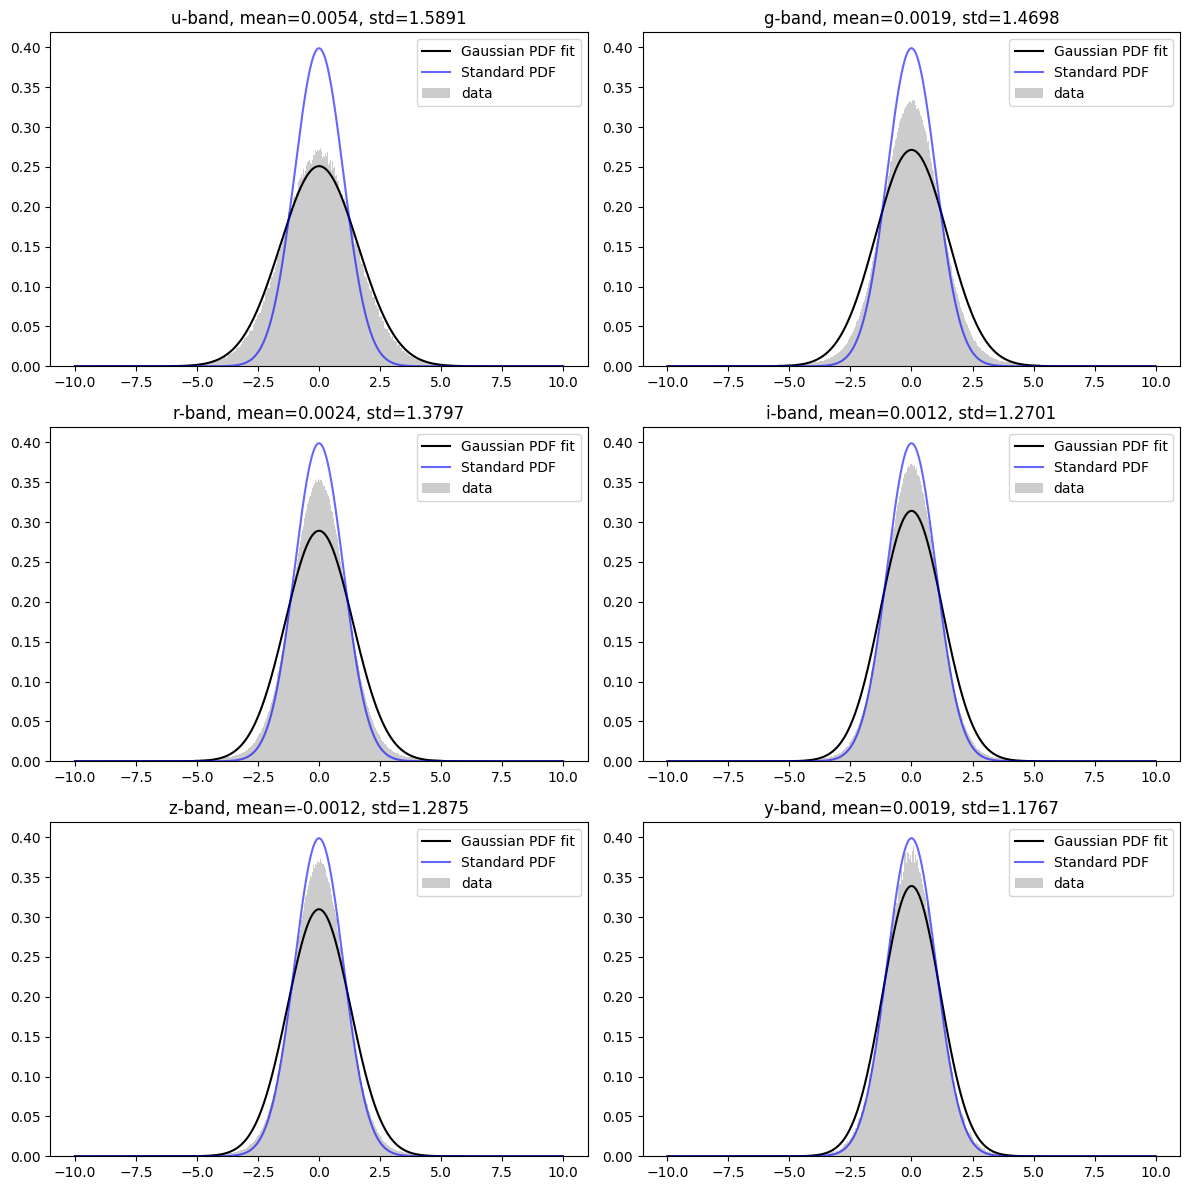

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    plot_hist(hists_df, axes[i], band)

plt.tight_layout()
plt.show()

## Plot for a magnitude bin

0.017377091377091536 1.4965663121051342
0.000566867001921878 1.43839844944502
0.0006493506493508994 1.319545512352096
-0.005979431454351203 1.159609225209515
-0.002548183354265987 1.048967524985084
0.0197082365091662 1.0260937147579916


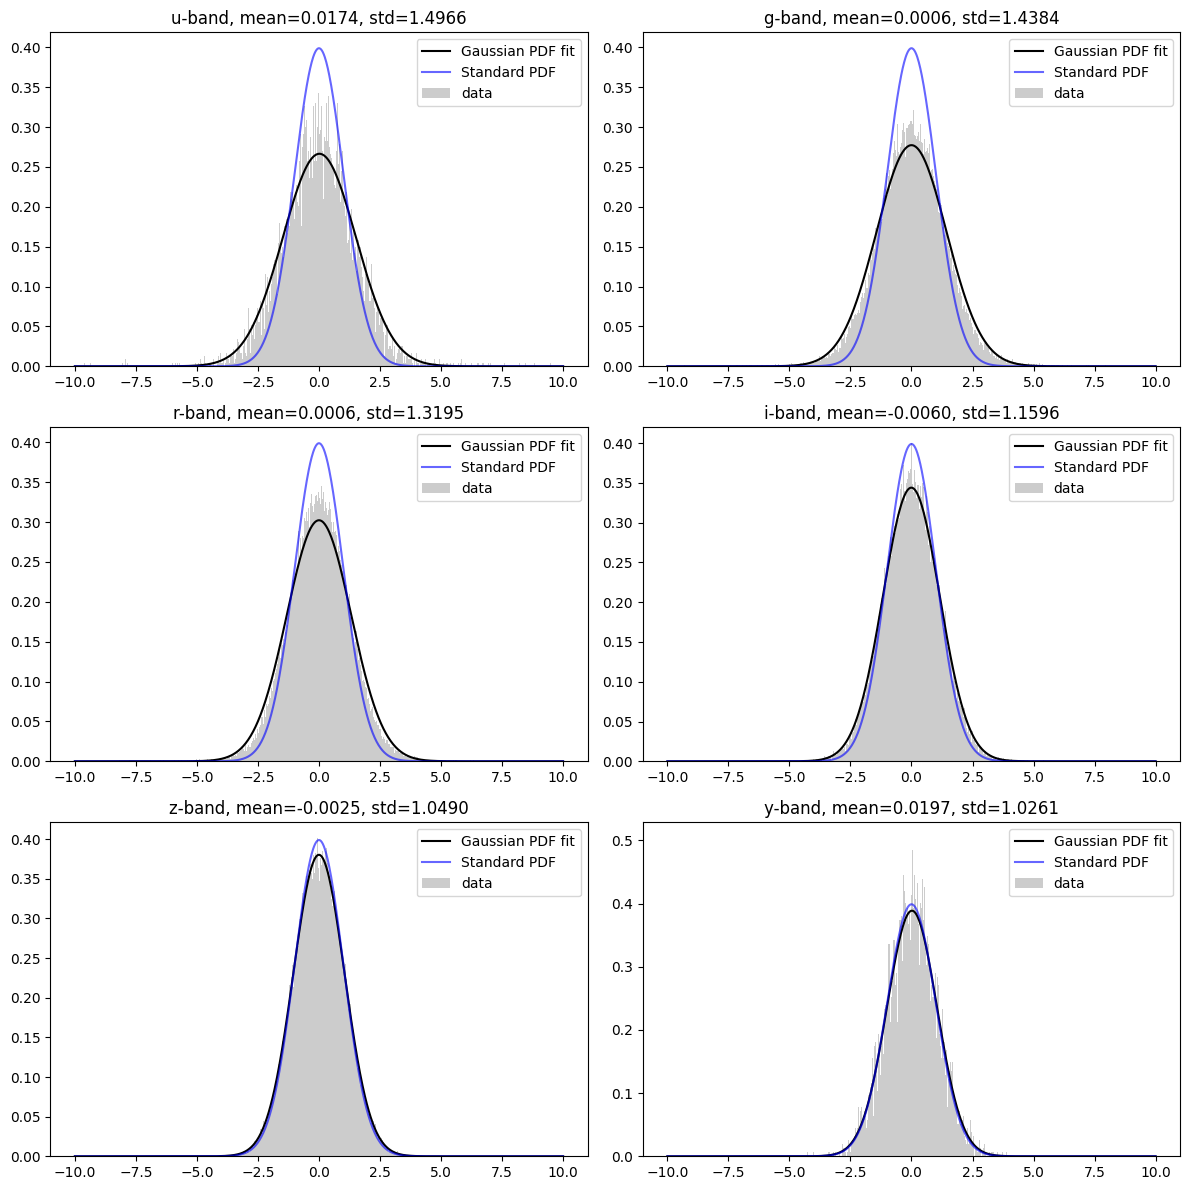

In [9]:
MAG = 21
mag_bin_idx = np.searchsorted(mag_bins, MAG)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    plot_hist(hists_df.query(f"mag_bin_idx == {mag_bin_idx}"), axes[i], band)

plt.tight_layout()
plt.show()

## Plot UU as a function of magnitude

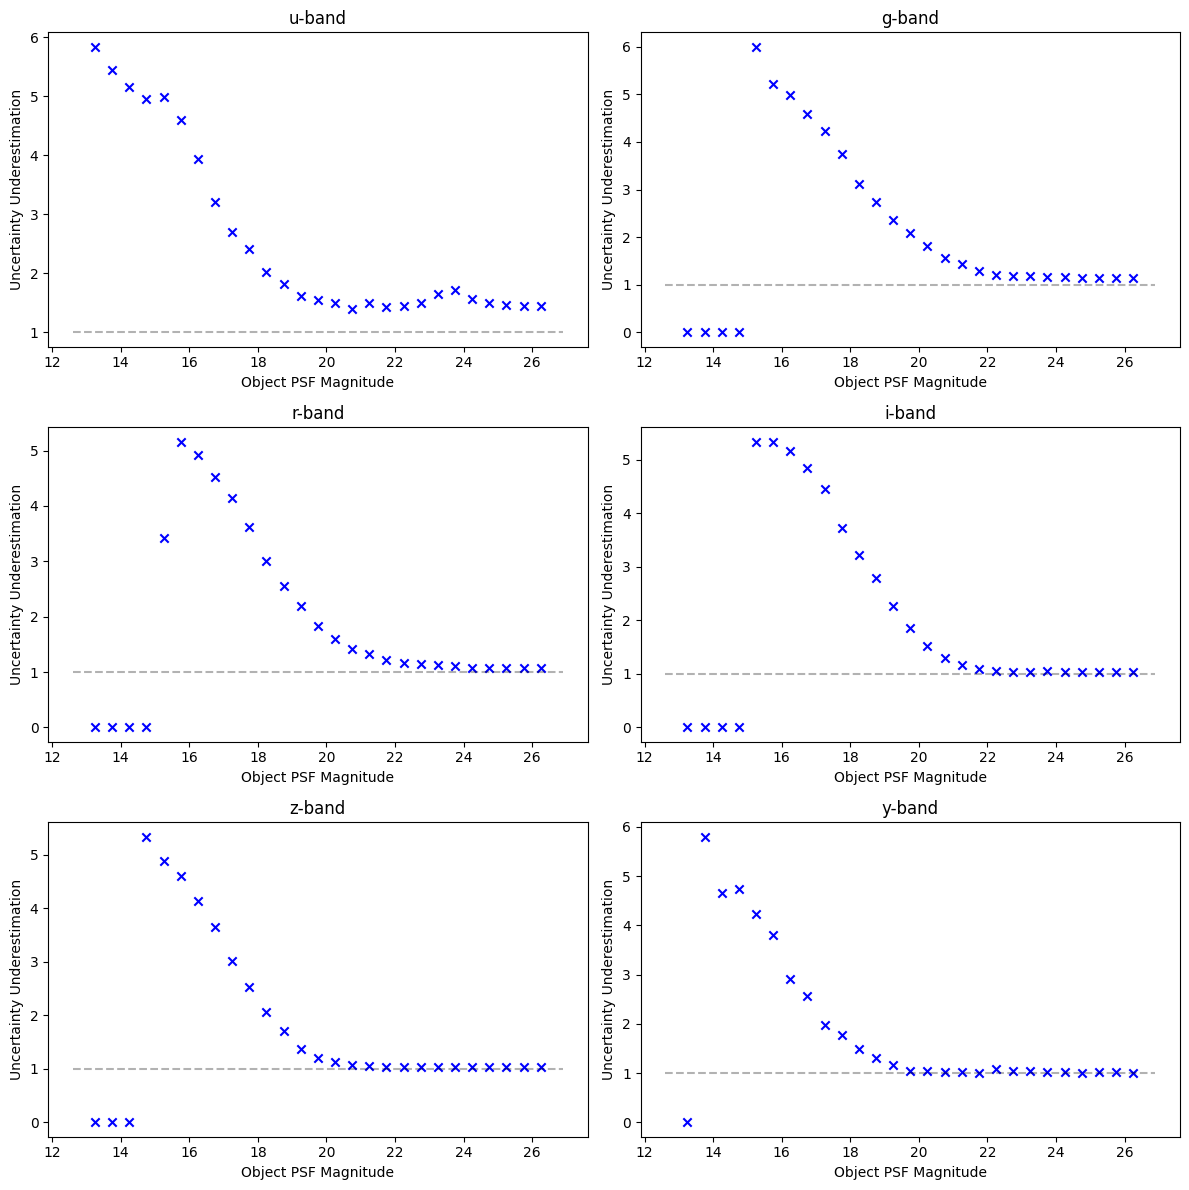

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    plot_magn_vs_uu(hists_df, axes[i], band)

plt.tight_layout()
plt.show()